In [91]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import xgboost
import random
import pickle

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [84]:
con = sqlite3.connect('database.db')
cur = con.cursor()

In [85]:
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# here is you table list
print(table_list)

[('player',), ('transaction',), ('transfer_suggestion',), ('fifa_rating',), ('team',), ('sessionteam',), ('sessionbudget',), ('player_mapping',), ('player_attributes',), ('absence',), ('fixture',), ('result',), ('player_prediction',), ('player_score',)]


In [119]:
con = sqlite3.connect('database.db')
cur = con.cursor()

injury = pd.read_sql_query("SELECT * FROM absence", con)
fixture = pd.read_sql_query("SELECT * FROM fixture", con)
result = pd.read_sql_query("SELECT * FROM result", con)

player_attributes = pd.read_sql_query("SELECT * FROM player_attributes", con)
# player_attributes['frac_change'] = player_attributes.transfers_balance/player_attributes.selected

df_player = pd.read_sql_query("SELECT * FROM player", con)
player_score = pd.read_sql_query("SELECT * FROM player_score", con)
player_score_list = []
for id_ in player_score.player_id.unique():
    temp_player = player_score[player_score.player_id == id_].copy()
    fixture_time_list = []
    team_G = []
    team_Gc = []
    p_att = []
    p_mid = []
    p_defn = []
    p_ovr = []
    o_att = []
    o_mid = []
    o_defn = []
    o_ovr = []
    for fix in temp_player.fixture_id:
        fixture_part = fixture[fixture.fixture_id == fix]
        result_part = result[result.fixture_id == fix]
        
        fixture_time_list.append(pd.to_datetime(fixture[fixture.fixture_id == fix].date.iloc[0].split('T')[0]))
        fifa_season = fifa[fifa.season == fixture_part.season.iloc[0]]  #.home_team.iloc[0]
        fifa_player_team = fifa_season[fifa_season.team == temp_player[temp_player.fixture_id == fix].player_team.iloc[0]]
        fifa_opponent_team = fifa_season[fifa_season.team == temp_player[temp_player.fixture_id == fix].opponent.iloc[0]]

        p_att.append(fifa_player_team.att.iloc[0])
        p_mid.append(fifa_player_team.mid.iloc[0])
        p_defn.append(fifa_player_team.defn.iloc[0])
        p_ovr.append(fifa_player_team.ovr.iloc[0])

        o_att.append(fifa_opponent_team.att.iloc[0])
        o_mid.append(fifa_opponent_team.mid.iloc[0])
        o_defn.append(fifa_opponent_team.defn.iloc[0])
        o_ovr.append(fifa_opponent_team.ovr.iloc[0])
        
        if temp_player[temp_player.fixture_id == fix].player_team.iloc[0] == fixture_part.home_team.iloc[0]:
            team_G.append(result_part.home_score.iloc[0])
            team_Gc.append(result_part.away_score.iloc[0])
        else:
            team_G.append(result_part.away_score.iloc[0])
            team_Gc.append(result_part.home_score.iloc[0])
    
    
    temp_player['datetime'] = fixture_time_list
    temp_player['team_G'] = team_G
    temp_player['team_Gc'] = team_Gc

    temp_player['p_att'] = p_att
    temp_player['p_mid'] = p_mid
    temp_player['p_defn'] = p_defn
    temp_player['p_ovr'] = p_ovr

    temp_player['o_att'] = o_att
    temp_player['o_mid'] = o_mid
    temp_player['o_defn'] = o_defn
    temp_player['o_ovr'] = o_ovr
    
    # temp_player['frac_change'] = player_attributes[player_attributes.player_id == id_].frac_change
    temp_player.reset_index(inplace=True)
    player_score_list.append(temp_player)
    
for i_player in range(len(player_score_list)):
    injury_player = injury[injury.player_id == player_score_list[i_player].player_id.iloc[0]]
    drop_list = []
    if len(injury_player) > 0:
        for i_injury in range(len(injury_player)):
            if injury_player.date_until.iloc[i_injury] == None:
                for i_date in range(len(player_score_list[i_player])):
                    if (pd.to_datetime(injury_player.date_from.iloc[i_injury]) < player_score_list[i_player]['datetime'].iloc[i_date]) & (pd.to_datetime(injury_player.date_from.iloc[i_injury]) + pd.Timedelta(days=1) > player_score_list[i_player]['datetime'].iloc[i_date]):
                        drop_list.append(i_date)
                    # injury_player.loc[i_injury, 'date_until'] = pd.to_datetime(injury_player.date_from.iloc[i_injury]) + pd.Timedelta(days=1)
            else:
                for i_date in range(len(player_score_list[i_player])):
                    if (pd.to_datetime(injury_player.date_from.iloc[i_injury]) < player_score_list[i_player]['datetime'].iloc[i_date]) & (pd.to_datetime(injury_player.date_until.iloc[i_injury]) > player_score_list[i_player]['datetime'].iloc[i_date]):
                        drop_list.append(i_date)
    player_score_list[i_player].drop(drop_list, inplace=True)
    
relevant_cols = list(player_score_list[0].columns[3:][:7]) + list(player_score_list[0].columns[3:][10:])
rem_cols = []
for col, i_col in zip(relevant_cols, range(len(relevant_cols))):
    if col in ['opponent', 'datetime']:
        rem_cols.append(i_col)

for i_col in np.sort(rem_cols)[::-1]:
    del relevant_cols[i_col]

train_dict = {}
val_dict = {}
for pos in player_attributes.position.unique():
    train_dict[pos] = pd.DataFrame({})
    val_dict[pos] = pd.DataFrame({})
    for i in range(4):
        for col in relevant_cols:
            train_dict[pos][col + '_' + str(i)] = []
            val_dict[pos][col + '_' + str(i)] = []
    train_dict[pos]['out'] = []
    val_dict[pos]['out'] = []
for i in tqdm(range(len(player_score_list))):
    if len(player_score_list[i]) > 0:
        choice = random.random()
        pos = player_attributes[player_attributes.player_id == player_score_list[i].player_id.iloc[0]].position.iloc[0]
        for j in range(len(player_score_list[i]) - 4):
            temp = []
            season_list = []
            for k in range(4):
                season_list.append(fixture[fixture.fixture_id == player_score_list[i].fixture_id.iloc[j + k]].season)
                temp += list(player_score_list[i].iloc[j + k][relevant_cols])
            if len(np.unique(season_list)) == 1:
                temp.append(player_score_list[i].iloc[j + 4]['minutes'])
                if choice < 0.8:
                    train_dict[pos].loc[len(train_dict[pos])] = temp
                else:
                    val_dict[pos].loc[len(val_dict[pos])] = temp
    # if i > 1000:
    #     break

with open('2025-reg-hack-week-airsenal/datasets/training_dictionary.pkl', 'wb') as f:
    pickle.dump(train_dict, f)

with open('2025-reg-hack-week-airsenal/datasets/validation_dictionary.pkl', 'wb') as f:
    pickle.dump(val_dict, f)
        
# with open('saved_dictionary.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)

100%|███████████████████████████████████████| 1381/1381 [01:57<00:00, 11.73it/s]


/Users/llauritsen/anaconda3/envs/airspace/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,321 (32.50 KB)

 Trainable params: 8,321 (32.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 846.8661 - val_loss: 231.9391
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 477.8441 - val_loss: 216.1914
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 403.6635 - val_loss: 213.0893
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 408.0800 - val_loss: 213.8041
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 383.1244 - val_loss: 215.9697
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 357.0922 - val_loss: 213.7003
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 394.5425 - val_loss: 224.9044
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 391.6439 - val_loss: 212.9162
Epoch 9/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 357.5156 - val_loss: 239.8009
Epoch 10/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 361.1724 - val_loss: 214.8218
Epoch 11/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 356.1438 - val_loss: 214.3293
Epoch 12/3

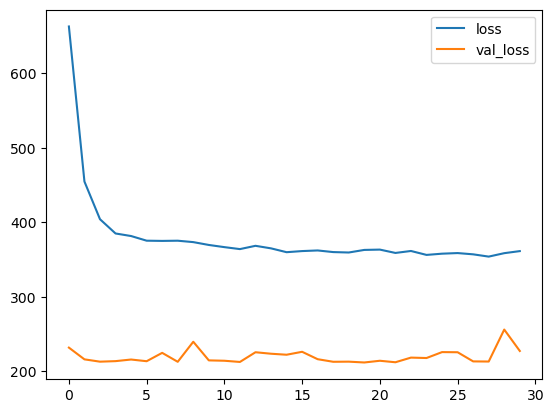

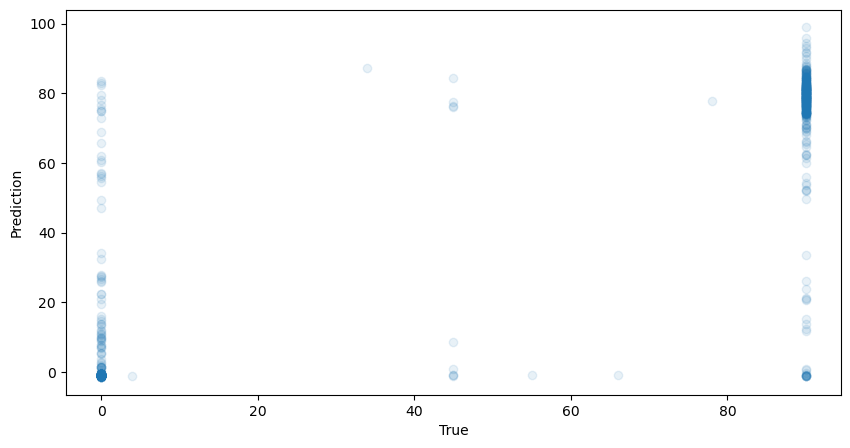

6.379594423320659


In [120]:
pos = 'GK'

train_df = train_dict[pos] #full_dict[pos].sample(frac=0.75, random_state=4)
drop_train = np.sort(random.sample([d[0] for d in np.argwhere([True if t_o == 0 else False for t_o in train_df['out']])], int(0.6*len(np.argwhere([True if t_o == 0 else False for t_o in train_df['out']])))))
train_df.drop(drop_train)
val_df = val_dict[pos] #full_dict[pos].drop(train_df.index)

input_shape = np.shape(train_df.columns[:-1])

model = tf.keras.Sequential([

    tf.keras.layers.Dense(units=64, activation='leaky_relu',
                          input_shape=input_shape),
    # tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    # tf.keras.layers.Dense(units=128, activation='leaky_relu',
    #                       input_shape=input_shape),
    tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    #tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    tf.keras.layers.Dense(units=1, activation='leaky_relu') #sigmoid')
])

model.compile(optimizer='adam', loss='mse') #'binary_crossentropy') #'mse')

model.summary()

# val_round = np.array([1 if val_out > 60 else 0 for val_out in list(val_df['out'])])
# train_round = np.array([1 if train_out > 60 else 0 for train_out in list(train_df['out'])])

val_round = np.array([val_out for val_out in list(val_df['out'])])
train_round = np.array([train_out for train_out in list(train_df['out'])])

losses = model.fit(train_df[train_df.columns[:-1]], train_round, validation_data=(val_df[train_df.columns[:-1]], val_round), batch_size=128, epochs=30)

loss_df = pd.DataFrame(losses.history)

loss_df.loc[:,['loss','val_loss']].plot()

pred = model.predict(val_df[train_df.columns[:-1]])

# plt.figure(figsize=(10,5))
# plt.scatter(val_df['out'], pred, alpha=0.1)
# plt.xlabel('True')
# plt.ylabel('Prediction')
# plt.show()

pred_round = [round(pred_[0]) for pred_ in pred]

plt.figure(figsize=(10,5))
plt.scatter(val_round, pred, alpha=0.1)
plt.xlabel('True')
plt.ylabel('Prediction')
plt.show()

print (sum([abs(pred_round[i] - val_round[i]) for i in range(len(pred))])/len(pred))

/Users/llauritsen/anaconda3/envs/airspace/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,369 (40.50 KB)

 Trainable params: 10,369 (40.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1146.6764 - val_loss: 670.9328
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 763.1627 - val_loss: 667.9839
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 731.4130 - val_loss: 665.4656
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 697.0609 - val_loss: 665.6001
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 689.4209 - val_loss: 665.2296
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 709.2881 - val_loss: 668.5310
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 698.2023 - val_loss: 682.2491
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 690.7320 - val_loss: 677.1226
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 702.8005 - val_loss: 666.8858
Epoch 10/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 669.9068 - val_loss: 686.4973
Epoch 11/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 687.0823 - val_loss: 658.3444
Epoch 12/

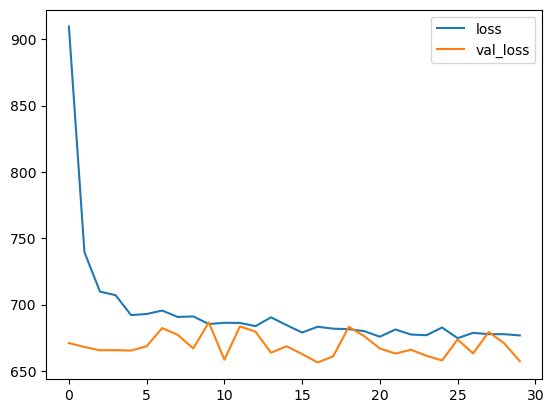

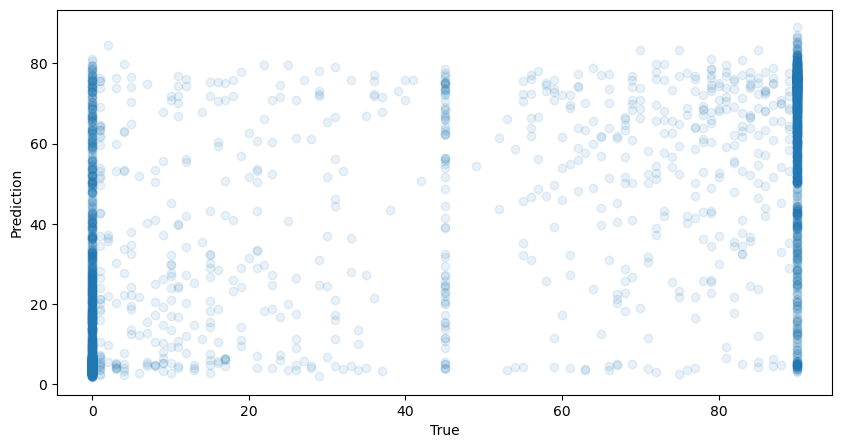

17.14019465727894


In [121]:
pos = 'DEF'

train_df = train_dict[pos] #full_dict[pos].sample(frac=0.75, random_state=4)
drop_train = np.sort(random.sample([d[0] for d in np.argwhere([True if t_o == 0 else False for t_o in train_df['out']])], int(0.6*len(np.argwhere([True if t_o == 0 else False for t_o in train_df['out']])))))
train_df.drop(drop_train)
val_df = val_dict[pos] #full_dict[pos].drop(train_df.index)

input_shape = np.shape(train_df.columns[:-1])

model = tf.keras.Sequential([

    tf.keras.layers.Dense(units=64, activation='leaky_relu',
                          input_shape=input_shape),
    # tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    # tf.keras.layers.Dense(units=128, activation='leaky_relu',
    #                       input_shape=input_shape),
    tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    tf.keras.layers.Dense(units=32, activation='leaky_relu'),
    tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    #tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    tf.keras.layers.Dense(units=1, activation='leaky_relu') #sigmoid')
])

model.compile(optimizer='adam', loss='mse') #'binary_crossentropy') #'mse')

model.summary()

# val_round = np.array([1 if val_out > 60 else 0 for val_out in list(val_df['out'])])
# train_round = np.array([1 if train_out > 60 else 0 for train_out in list(train_df['out'])])

val_round = np.array([val_out for val_out in list(val_df['out'])])
train_round = np.array([train_out for train_out in list(train_df['out'])])

losses = model.fit(train_df[train_df.columns[:-1]], train_round, validation_data=(val_df[train_df.columns[:-1]], val_round), batch_size=256, epochs=30)

loss_df = pd.DataFrame(losses.history)

loss_df.loc[:,['loss','val_loss']].plot()

pred = model.predict(val_df[train_df.columns[:-1]])

# plt.figure(figsize=(10,5))
# plt.scatter(val_df['out'], pred, alpha=0.1)
# plt.xlabel('True')
# plt.ylabel('Prediction')
# plt.show()

pred_round = [round(pred_[0]) for pred_ in pred]

plt.figure(figsize=(10,5))
plt.scatter(val_round, pred, alpha=0.1)
plt.xlabel('True')
plt.ylabel('Prediction')
plt.show()

print (sum([abs(pred_round[i] - val_round[i]) for i in range(len(pred))])/len(pred))

/Users/llauritsen/anaconda3/envs/airspace/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,369 (40.50 KB)

 Trainable params: 10,369 (40.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 723.8515 - val_loss: 502.5020
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 539.8352 - val_loss: 499.3788
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 523.5851 - val_loss: 503.2124
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 530.4115 - val_loss: 519.4072
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 529.5182 - val_loss: 509.7092
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 530.4813 - val_loss: 498.0139
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 515.5284 - val_loss: 493.5153
Epoch 8/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 514.8206 - val_loss: 488.9271
Epoch 9/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 517.4178 - val_loss: 491.9946
Epoch 10/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 526.1025 - val_loss: 486.1129
Epoch 11/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 516.6229 - val_l

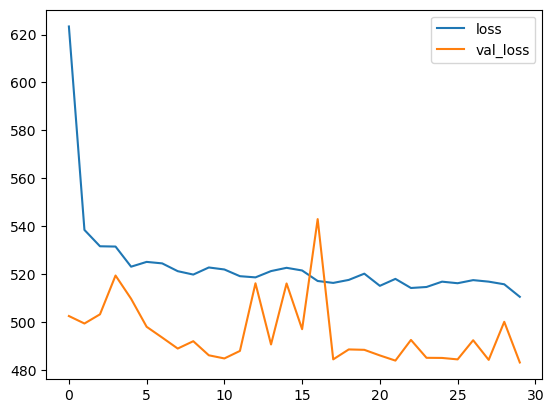

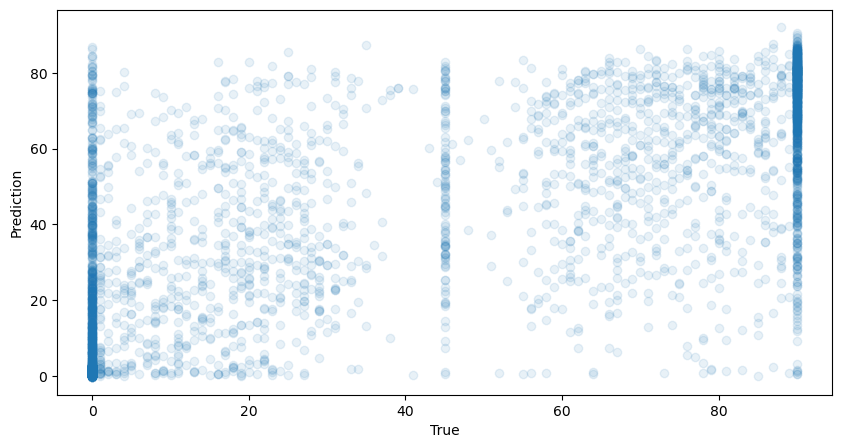

13.45873137179977


In [122]:
pos = 'MID'

train_df = train_dict[pos] #full_dict[pos].sample(frac=0.75, random_state=4)
drop_train = np.sort(random.sample([d[0] for d in np.argwhere([True if t_o == 0 else False for t_o in train_df['out']])], int(0.6*len(np.argwhere([True if t_o == 0 else False for t_o in train_df['out']])))))
train_df.drop(drop_train)
val_df = val_dict[pos] #full_dict[pos].drop(train_df.index)

input_shape = np.shape(train_df.columns[:-1])

model = tf.keras.Sequential([

    tf.keras.layers.Dense(units=64, activation='leaky_relu',
                          input_shape=input_shape),
    # tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    # tf.keras.layers.Dense(units=128, activation='leaky_relu',
    #                       input_shape=input_shape),
    tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    tf.keras.layers.Dense(units=32, activation='leaky_relu'),
    tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    #tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    tf.keras.layers.Dense(units=1, activation='leaky_relu') #sigmoid')
])

model.compile(optimizer='adam', loss='mse') #'binary_crossentropy') #'mse')

model.summary()

# val_round = np.array([1 if val_out > 60 else 0 for val_out in list(val_df['out'])])
# train_round = np.array([1 if train_out > 60 else 0 for train_out in list(train_df['out'])])

val_round = np.array([val_out for val_out in list(val_df['out'])])
train_round = np.array([train_out for train_out in list(train_df['out'])])

losses = model.fit(train_df[train_df.columns[:-1]], train_round, validation_data=(val_df[train_df.columns[:-1]], val_round), batch_size=128, epochs=30)

loss_df = pd.DataFrame(losses.history)

loss_df.loc[:,['loss','val_loss']].plot()

pred = model.predict(val_df[train_df.columns[:-1]])

# plt.figure(figsize=(10,5))
# plt.scatter(val_df['out'], pred, alpha=0.1)
# plt.xlabel('True')
# plt.ylabel('Prediction')
# plt.show()

pred_round = [round(pred_[0]) for pred_ in pred]

plt.figure(figsize=(10,5))
plt.scatter(val_round, pred, alpha=0.1)
plt.xlabel('True')
plt.ylabel('Prediction')
plt.show()

print (sum([abs(pred_round[i] - val_round[i]) for i in range(len(pred))])/len(pred))

/Users/llauritsen/anaconda3/envs/airspace/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,369 (40.50 KB)

 Trainable params: 10,369 (40.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 906.5729 - val_loss: 501.4313
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 495.7317 - val_loss: 495.2390
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 492.0258 - val_loss: 482.0858
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 452.2669 - val_loss: 477.0873
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 432.2975 - val_loss: 485.9931
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 437.4163 - val_loss: 476.4752
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 447.7527 - val_loss: 473.1958
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 440.4631 - val_loss: 481.6895
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 435.1467 - val_loss: 472.7490
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 435.4054 - val_loss: 473.6745
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 457.0066 - val_loss: 480.3692
Epoch 12/3

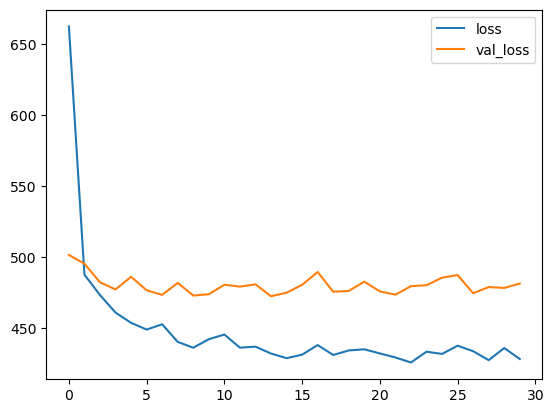

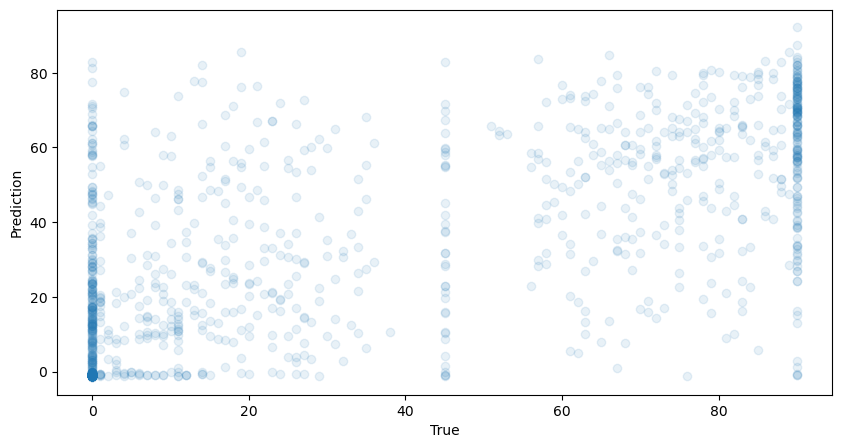

13.263473053892216


In [123]:
pos = 'FWD'

train_df = train_dict[pos] #full_dict[pos].sample(frac=0.75, random_state=4)
drop_train = np.sort(random.sample([d[0] for d in np.argwhere([True if t_o == 0 else False for t_o in train_df['out']])], int(0.6*len(np.argwhere([True if t_o == 0 else False for t_o in train_df['out']])))))
train_df.drop(drop_train)
val_df = val_dict[pos] #full_dict[pos].drop(train_df.index)

input_shape = np.shape(train_df.columns[:-1])

model = tf.keras.Sequential([

    tf.keras.layers.Dense(units=64, activation='leaky_relu',
                          input_shape=input_shape),
    # tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    # tf.keras.layers.Dense(units=128, activation='leaky_relu',
    #                       input_shape=input_shape),
    tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    tf.keras.layers.Dense(units=32, activation='leaky_relu'),
    tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    #tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    tf.keras.layers.Dense(units=1, activation='leaky_relu') #sigmoid')
])

model.compile(optimizer='adam', loss='mse') #'binary_crossentropy') #'mse')

model.summary()

# val_round = np.array([1 if val_out > 60 else 0 for val_out in list(val_df['out'])])
# train_round = np.array([1 if train_out > 60 else 0 for train_out in list(train_df['out'])])

val_round = np.array([val_out for val_out in list(val_df['out'])])
train_round = np.array([train_out for train_out in list(train_df['out'])])

losses = model.fit(train_df[train_df.columns[:-1]], train_round, validation_data=(val_df[train_df.columns[:-1]], val_round), batch_size=128, epochs=30)

loss_df = pd.DataFrame(losses.history)

loss_df.loc[:,['loss','val_loss']].plot()

pred = model.predict(val_df[train_df.columns[:-1]])

# plt.figure(figsize=(10,5))
# plt.scatter(val_df['out'], pred, alpha=0.1)
# plt.xlabel('True')
# plt.ylabel('Prediction')
# plt.show()

pred_round = [round(pred_[0]) for pred_ in pred]

plt.figure(figsize=(10,5))
plt.scatter(val_round, pred, alpha=0.1)
plt.xlabel('True')
plt.ylabel('Prediction')
plt.show()

print (sum([abs(pred_round[i] - val_round[i]) for i in range(len(pred))])/len(pred))

<Axes: >

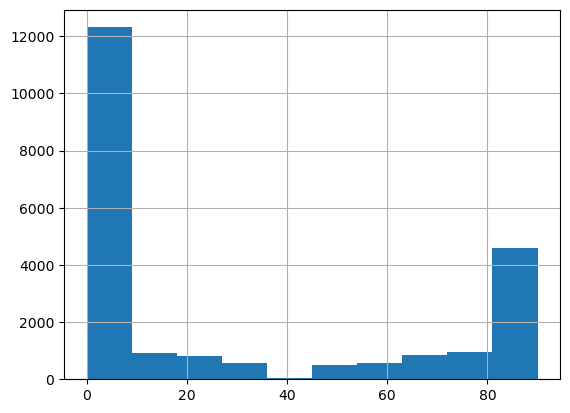

In [499]:
train_df.out.hist()

<Axes: >

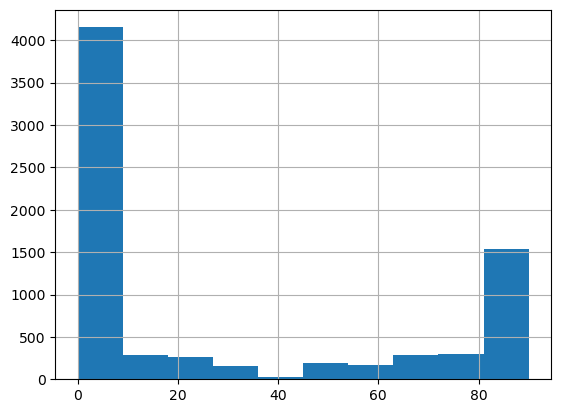

In [500]:
val_df.out.hist()

In [ ]:
pred_round = [round(pred_[0]) for pred_ in pred]
sum([abs(pred_round[i] - val_round[i]) for i in range(len(pred))])/len(pred)

In [241]:
pred[0]

array([0.06240175], dtype=float32)

In [390]:
sum(val_round)

0

In [109]:
list(player_score_list[0].columns[3:][:6]) + list(player_score_list[0].columns[3:][8:])

['opponent',
 'points',
 'goals',
 'assists',
 'bonus',
 'conceded',
 'result_id',
 'fixture_id',
 'clean_sheets',
 'own_goals',
 'penalties_saved',
 'penalties_missed',
 'yellow_cards',
 'red_cards',
 'saves',
 'bps',
 'influence',
 'creativity',
 'threat',
 'ict_index',
 'expected_goals',
 'expected_assists',
 'expected_goal_involvements',
 'expected_goals_conceded',
 'datetime',
 'team_G',
 'team_Gc',
 'p_att',
 'p_mid',
 'p_defn',
 'p_ovr',
 'o_att',
 'o_mid',
 'o_defn',
 'o_ovr']

In [116]:
list(player_score_list[0].columns[3:][:7])

['opponent', 'points', 'goals', 'assists', 'bonus', 'conceded', 'minutes']

In [118]:
list(player_score_list[0].columns[3:][10:])

['clean_sheets',
 'own_goals',
 'penalties_saved',
 'penalties_missed',
 'yellow_cards',
 'red_cards',
 'saves',
 'bps',
 'influence',
 'creativity',
 'threat',
 'ict_index',
 'expected_goals',
 'expected_assists',
 'expected_goal_involvements',
 'expected_goals_conceded',
 'datetime',
 'team_G',
 'team_Gc',
 'p_att',
 'p_mid',
 'p_defn',
 'p_ovr',
 'o_att',
 'o_mid',
 'o_defn',
 'o_ovr']

In [105]:
list(train_df.columns)

['points_0',
 'goals_0',
 'assists_0',
 'bonus_0',
 'conceded_0',
 'fixture_id_0',
 'clean_sheets_0',
 'own_goals_0',
 'penalties_saved_0',
 'penalties_missed_0',
 'yellow_cards_0',
 'red_cards_0',
 'saves_0',
 'bps_0',
 'influence_0',
 'creativity_0',
 'threat_0',
 'ict_index_0',
 'expected_goals_0',
 'expected_assists_0',
 'expected_goal_involvements_0',
 'expected_goals_conceded_0',
 'team_G_0',
 'team_Gc_0',
 'p_att_0',
 'p_mid_0',
 'p_defn_0',
 'p_ovr_0',
 'o_att_0',
 'o_mid_0',
 'o_defn_0',
 'o_ovr_0',
 'points_1',
 'goals_1',
 'assists_1',
 'bonus_1',
 'conceded_1',
 'fixture_id_1',
 'clean_sheets_1',
 'own_goals_1',
 'penalties_saved_1',
 'penalties_missed_1',
 'yellow_cards_1',
 'red_cards_1',
 'saves_1',
 'bps_1',
 'influence_1',
 'creativity_1',
 'threat_1',
 'ict_index_1',
 'expected_goals_1',
 'expected_assists_1',
 'expected_goal_involvements_1',
 'expected_goals_conceded_1',
 'team_G_1',
 'team_Gc_1',
 'p_att_1',
 'p_mid_1',
 'p_defn_1',
 'p_ovr_1',
 'o_att_1',
 'o_mid_1

In [106]:
relevant_cols

['points',
 'goals',
 'assists',
 'bonus',
 'conceded',
 'fixture_id',
 'clean_sheets',
 'own_goals',
 'penalties_saved',
 'penalties_missed',
 'yellow_cards',
 'red_cards',
 'saves',
 'bps',
 'influence',
 'creativity',
 'threat',
 'ict_index',
 'expected_goals',
 'expected_assists',
 'expected_goal_involvements',
 'expected_goals_conceded',
 'team_G',
 'team_Gc',
 'p_att',
 'p_mid',
 'p_defn',
 'p_ovr',
 'o_att',
 'o_mid',
 'o_defn',
 'o_ovr']

Epoch 1/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 373us/step - loss: 734.8900 - val_loss: 674.4083
Epoch 2/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 340us/step - loss: 690.7148 - val_loss: 674.9283
Epoch 3/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - loss: 699.7871 - val_loss: 695.5148
Epoch 4/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 338us/step - loss: 686.0697 - val_loss: 673.2390
Epoch 5/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step - loss: 697.3524 - val_loss: 680.9540
Epoch 6/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 339us/step - loss: 690.8986 - val_loss: 684.3608
Epoch 7/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 343us/step - loss: 695.3264 - val_loss: 671.0057
Epoch 8/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 344us/step - loss: 674.8686 - val_loss: 670.9692
Epoch 9/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 341us/step - loss: 692.5473 - val_loss: 675.6692
Epoch 10/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 346us/step - loss: 694.7142 - val_loss: 669.2950
Epoch 11/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - 

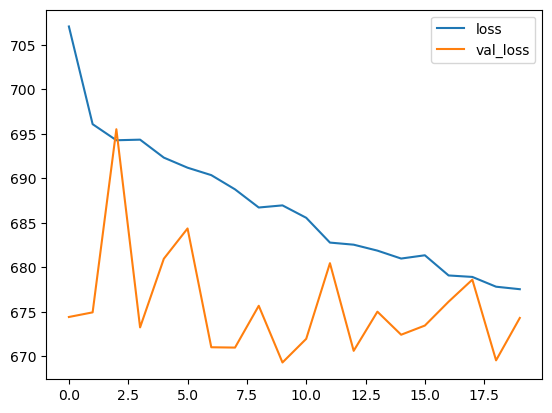

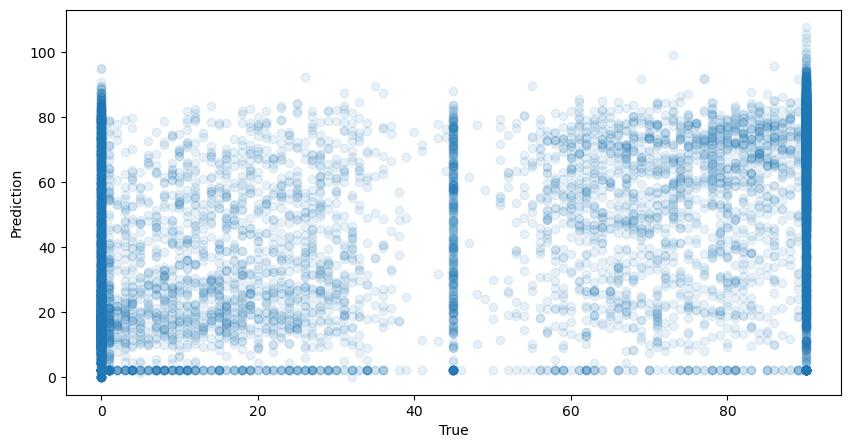

In [233]:
losses = model.fit(train_df[train_df.columns[:-1]], train_df['out'], validation_data=(val_df[train_df.columns[:-1]], val_df['out']), batch_size=24, epochs=20)

loss_df = pd.DataFrame(losses.history)

loss_df.loc[:,['loss','val_loss']].plot()

pred = model.predict(val_df[train_df.columns[:-1]])

plt.figure(figsize=(10,5))
plt.scatter(val_df['out'], pred, alpha=0.1)
plt.xlabel('True')
plt.ylabel('Prediction')
plt.show()

In [234]:
pred_round = np.array([1 if pred_[0] > 60 else 0 for pred_ in pred])
val_round = np.array([1 if val_out > 60 else 0 for val_out in list(val_df['out'])])
sum([abs(pred_round[i] - val_round[i]) for i in range(len(pred_round))])/len(pred_round)

# pred_round = np.array([round(pred_[0]/90) for pred_ in pred])
# val_round = np.array([round(val_out/90) for val_out in list(val_df['out'])])
# sum([abs(pred_round[i] - val_round[i]) for i in range(len(pred_round))])/len(pred_round)

0.15167594830303668

In [196]:
val_round

array([0, 0, 0, ..., 1, 1, 1])

In [183]:
round(pred[1][0])

1

0.14274779946421737

In [118]:
val_df['out']

6         0.0
14        0.0
31       45.0
39        0.0
44        0.0
         ... 
20876    90.0
20889    90.0
20892    90.0
20893    90.0
20894    90.0
Name: out, Length: 5226, dtype: float64

In [123]:
pred - np.array(val_df['out'])

array([[  6.81342411,   6.81342411, -38.18657589, ..., -83.18657589,
        -83.18657589, -83.18657589],
       [ 45.70088959,  45.70088959,   0.70088959, ..., -44.29911041,
        -44.29911041, -44.29911041],
       [ 47.19889832,  47.19889832,   2.19889832, ..., -42.80110168,
        -42.80110168, -42.80110168],
       ...,
       [ 95.59453583,  95.59453583,  50.59453583, ...,   5.59453583,
          5.59453583,   5.59453583],
       [ 95.69671631,  95.69671631,  50.69671631, ...,   5.69671631,
          5.69671631,   5.69671631],
       [ 95.58895874,  95.58895874,  50.58895874, ...,   5.58895874,
          5.58895874,   5.58895874]])

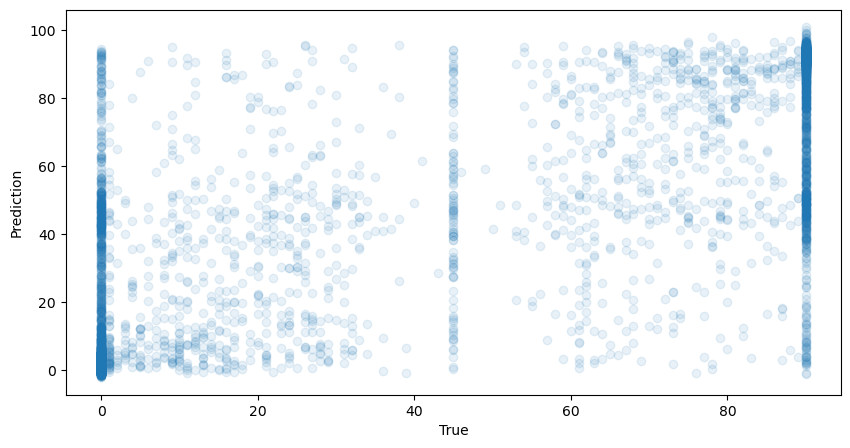

In [112]:
np.shape(val_df.iloc[0:3][:-1])

(2, 101)

In [111]:
input_shape

(100,)

In [29]:
player_time_set_background[0]

[1,
 0,
 0,
 0,
 0,
 4,
 424,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 4.2,
 0.1,
 4.0,
 0.8,
 0.02,
 0.0,
 0.02,
 0.19,
 1,
 0,
 0,
 0,
 0,
 5,
 424,
 13,
 13,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1.0,
 0.3,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0]

In [38]:
table_list

[('player',),
 ('transaction',),
 ('transfer_suggestion',),
 ('fifa_rating',),
 ('team',),
 ('sessionteam',),
 ('sessionbudget',),
 ('player_mapping',),
 ('player_attributes',),
 ('absence',),
 ('fixture',),
 ('result',),
 ('player_prediction',),
 ('player_score',)]

In [32]:
df_absence = pd.read_sql_query("SELECT * FROM absence", con)
df_absence

,id,player_id,season,reason,details,date_from,date_until,gw_from,gw_until,url,timestamp
0,1,522,2425,injury,Ankle injury,2025-02-14,2025-04-28,25,35.0,/amad-diallo/profil/spieler/536835,2025-06-09T12:15:38.774168
1,2,689,2425,injury,Ill,2025-01-01,2025-01-17,20,22.0,/fraser-forster/profil/spieler/52570,2025-06-09T12:15:38.778684
2,3,581,2425,injury,Fitness,2025-03-03,2025-05-25,28,39.0,/jamaal-lascelles/profil/spieler/183318,2025-06-09T12:15:38.782880
3,4,485,2425,injury,unknown injury,2025-03-15,2025-03-17,29,30.0,/bernardo-silva/profil/spieler/241641,2025-06-09T12:15:38.787870
4,5,242,2425,injury,unknown injury,2025-04-30,2025-05-23,35,38.0,/christopher-nkunku/profil/spieler/344381,2025-06-09T12:15:38.792099
...,...,...,...,...,...,...,...,...,...,...,...
1404,1405,238,2223,injury,Ankle Injury,2022-07-28,2022-10-17,1,12.0,/noni-madueke/profil/spieler/503987,2025-06-09T12:15:41.015834
1405,1406,238,2223,Transfer,Transferred to PSV Eindhoven,2022-07-01,2023-01-19,1,21.0,/noni-madueke/profil/spieler/503987,2025-06-09T12:15:41.016019
1406,1407,1050,2223,injury,Foot Injury,2023-04-14,2023-05-08,31,36.0,/raphael-varane/profil/spieler/164770,2025-06-09T12:15:41.016216
1407,1408,1050,2223,injury,Leg Injury,2022-10-22,2022-11-14,13,17.0,/raphael-varane/profil/spieler/164770,2025-06-09T12:15:41.016416


In [36]:
df_player.merge(df_absence, on='player_id')

,player_id,fpl_api_id,name,id,season,reason,details,date_from,date_until,gw_from,gw_until,url,timestamp
0,2,None,Gabriel Fernando de Jesus,76,2425,injury,Cruciate ligament tear,2025-01-13,2025-11-22,21,39.0,/gabriel-jesus/profil/spieler/363205,2025-06-09T12:15:39.018662
1,2,None,Gabriel Fernando de Jesus,77,2425,injury,Groin injury,2024-08-20,2024-09-04,2,4.0,/gabriel-jesus/profil/spieler/363205,2025-06-09T12:15:39.022805
2,2,None,Gabriel Fernando de Jesus,661,2324,injury,Knee injury,2024-02-02,2024-02-24,23,26.0,/gabriel-jesus/profil/spieler/363205,2025-06-09T12:15:40.062110
3,2,None,Gabriel Fernando de Jesus,662,2324,injury,Knee injury,2024-01-05,2024-01-18,21,22.0,/gabriel-jesus/profil/spieler/363205,2025-06-09T12:15:40.062533
4,2,None,Gabriel Fernando de Jesus,663,2324,injury,Hamstring injury,2023-10-24,2023-11-19,10,13.0,/gabriel-jesus/profil/spieler/363205,2025-06-09T12:15:40.064792
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1357,None,Mislav Orsic,1403,2223,Transfer,Transferred to Dinamo Zagreb,2022-07-01,2023-01-05,1,20.0,/mislav-orsic/profil/spieler/119150,2025-06-09T12:15:41.013514
1405,1358,None,Carlos Alcaraz,1020,2223,Transfer,Transferred to Racing Club,2022-07-01,2023-01-10,1,20.0,/carlos-alcaraz/profil/spieler/748319,2025-06-09T12:15:40.582534
1406,1361,None,Lucas Rodrigues Moura da Silva,1216,2223,injury,Calf Injury,2022-08-29,2022-10-10,5,11.0,/lucas-moura/profil/spieler/77100,2025-06-09T12:15:40.860034
1407,1370,None,Vladimir Coufal,899,2223,injury,Hamstring Injury,2023-05-03,2023-05-16,35,37.0,/vladimir-coufal/profil/spieler/157672,2025-06-09T12:15:40.285142


In [37]:
df_absence.merge(df_player, on='player_id')

,id,player_id,season,reason,details,date_from,date_until,gw_from,gw_until,url,timestamp,fpl_api_id,name
0,1,522,2425,injury,Ankle injury,2025-02-14,2025-04-28,25,35.0,/amad-diallo/profil/spieler/536835,2025-06-09T12:15:38.774168,None,Amad Diallo
1,2,689,2425,injury,Ill,2025-01-01,2025-01-17,20,22.0,/fraser-forster/profil/spieler/52570,2025-06-09T12:15:38.778684,None,Fraser Forster
2,3,581,2425,injury,Fitness,2025-03-03,2025-05-25,28,39.0,/jamaal-lascelles/profil/spieler/183318,2025-06-09T12:15:38.782880,None,Jamaal Lascelles
3,4,485,2425,injury,unknown injury,2025-03-15,2025-03-17,29,30.0,/bernardo-silva/profil/spieler/241641,2025-06-09T12:15:38.787870,None,Bernardo Veiga de Carvalho e Silva
4,5,242,2425,injury,unknown injury,2025-04-30,2025-05-23,35,38.0,/christopher-nkunku/profil/spieler/344381,2025-06-09T12:15:38.792099,None,Christopher Nkunku
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1405,238,2223,injury,Ankle Injury,2022-07-28,2022-10-17,1,12.0,/noni-madueke/profil/spieler/503987,2025-06-09T12:15:41.015834,None,Noni Madueke
1405,1406,238,2223,Transfer,Transferred to PSV Eindhoven,2022-07-01,2023-01-19,1,21.0,/noni-madueke/profil/spieler/503987,2025-06-09T12:15:41.016019,None,Noni Madueke
1406,1407,1050,2223,injury,Foot Injury,2023-04-14,2023-05-08,31,36.0,/raphael-varane/profil/spieler/164770,2025-06-09T12:15:41.016216,None,Raphaël Varane
1407,1408,1050,2223,injury,Leg Injury,2022-10-22,2022-11-14,13,17.0,/raphael-varane/profil/spieler/164770,2025-06-09T12:15:41.016416,None,Raphaël Varane


In [22]:
i_row = 0
for row in cur.execute("SELECT * FROM absence"):
    if i_row < 10:
        print(row)
        i_row += 1
    else:
        break

(1, 522, '2425', 'injury', 'Ankle injury', '2025-02-14', '2025-04-28', 25, 35, '/amad-diallo/profil/spieler/536835', '2025-06-09T12:15:38.774168')
(2, 689, '2425', 'injury', 'Ill', '2025-01-01', '2025-01-17', 20, 22, '/fraser-forster/profil/spieler/52570', '2025-06-09T12:15:38.778684')
(3, 581, '2425', 'injury', 'Fitness', '2025-03-03', '2025-05-25', 28, 39, '/jamaal-lascelles/profil/spieler/183318', '2025-06-09T12:15:38.782880')
(4, 485, '2425', 'injury', 'unknown injury', '2025-03-15', '2025-03-17', 29, 30, '/bernardo-silva/profil/spieler/241641', '2025-06-09T12:15:38.787870')
(5, 242, '2425', 'injury', 'unknown injury', '2025-04-30', '2025-05-23', 35, 38, '/christopher-nkunku/profil/spieler/344381', '2025-06-09T12:15:38.792099')
(6, 242, '2425', 'injury', 'Knock', '2025-04-30', None, 35, None, '/christopher-nkunku/profil/spieler/344381', '2025-06-09T12:15:38.792316')
(7, 713, '2425', 'injury', 'Hamstring injury', '2024-10-27', '2025-02-13', 10, 25, '/wilson-odobert/profil/spieler/74

In [ ]:
# Be sure to close the connection
con.close()